#[Apache Spark 3.0.0 with Google Colab](http://apache.osuosl.org/spark/spark-3.0.0/)

**Author: MA Raza**

This is the working google collaboratory notebook example of setting up  recently release spark 3.0.0 in google colab. 

* Installing Java in the Google Colaboratory
* Setting up Spark 3.0 in the Google Colaboratory
* A test example

**References:**

1. http://apache.osuosl.org/spark/spark-3.0.0/
2. https://medium.com/@sushantgautam_930/apache-spark-in-google-collaboratory-in-3-steps-e0acbba654e6
3. https://notebooks.gesis.org/binder/jupyter/user/databricks-koalas-kuv5qckt/notebooks/docs/source/getting_started/10min.ipynb
4. https://medium.com/@amjadraza24/getting-started-spark3-0-0-with-google-colab-9796d350d78



# Setting up Spark 3.0.0 in the Google Colaboratory

This notebook comprises the instructions to run Sprak and pyspark in google colabboratory framework. 

We will be running the excises of  some basic functions on using koalas

We will install below programs

* Java 8
* spark-3.0.0
* Hadoop3.2 
* [Findspark](https://github.com/minrk/findspark)


This installs Apache Spark 3.0.0, Java 8, and [Findspark](https://github.com/minrk/findspark), a library that makes it easy for Python to find Spark.

Run below set of commands to install spark. 

**Change the location/version of spark version of your choice**

**[Apache Spark in Google Collaboratory In 3 steps.](https://medium.com/@sushantgautam_930/apache-spark-in-google-collaboratory-in-3-steps-e0acbba654e6)**

> Make sure the spark-version you are downloading is availbale on target link



In [2]:
# Run below commands
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [4]:
!ls -a

.	 sample_data			spark-3.0.1-bin-hadoop2.7.tgz.1
..	 sample_submission.csv		test.csv
.config  spark-3.0.1-bin-hadoop2.7	test_labels.csv
drive	 spark-3.0.1-bin-hadoop2.7.tgz	train.csv


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

## Spark Installation test
Lets test the installation of spark in our google colab environment. 

In [5]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
# Test the spark 
df = spark.createDataFrame([{"hello": "world"} for x in range(1000)])

df.show(3, False)


/content/spark-3.0.1-bin-hadoop2.7/python/pyspark/sql/session.py:381: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


+-----+
|hello|
+-----+
|world|
|world|
|world|
+-----+
only showing top 3 rows



In [6]:
# Check the pyspark version
import pyspark
print(pyspark.__version__)

3.0.1


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!unzip "/content/drive/My Drive/mgc_dataset/CS651Final/jigsaw-toxic-comment-classification-challenge/*.zip" -d "/content/drive/My Drive/mgc_dataset/CS651Final/jigsaw-toxic-comment-classification-challenge/"

Archive:  /content/drive/My Drive/mgc_dataset/CS651Final/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
replace /content/drive/My Drive/mgc_dataset/CS651Final/jigsaw-toxic-comment-classification-challenge/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [31]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StopWordsRemover 
from pyspark.ml import Pipeline
from pyspark.sql import SQLContext

In [24]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
TRAIN_FILE = "/content/drive/My Drive/mgc_dataset/CS651Final/jigsaw-toxic-comment-classification-challenge/train.csv"
TEST_DATA_FILE = "/content/drive/My Drive/mgc_dataset/CS651Final/jigsaw-toxic-comment-classification-challenge/test.csv"
TEST_LABEL = "/content/drive/My Drive/mgc_dataset/CS651Final/jigsaw-toxic-comment-classification-challenge/test_labels.csv"

train = pd.read_csv(TRAIN_FILE)
test_data = pd.read_csv(TEST_DATA_FILE)
test_label =  pd.read_csv(TEST_LABEL)
print("training data shape",train.shape)
print("testing data shape",test_data.shape)
print("testing data label shape",test_label.shape)

training data shape (159571, 8)
testing data shape (153164, 2)
testing data label shape (153164, 7)


In [11]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [28]:
test_data.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [29]:
test_label.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,-1,-1,-1,-1,-1,-1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn

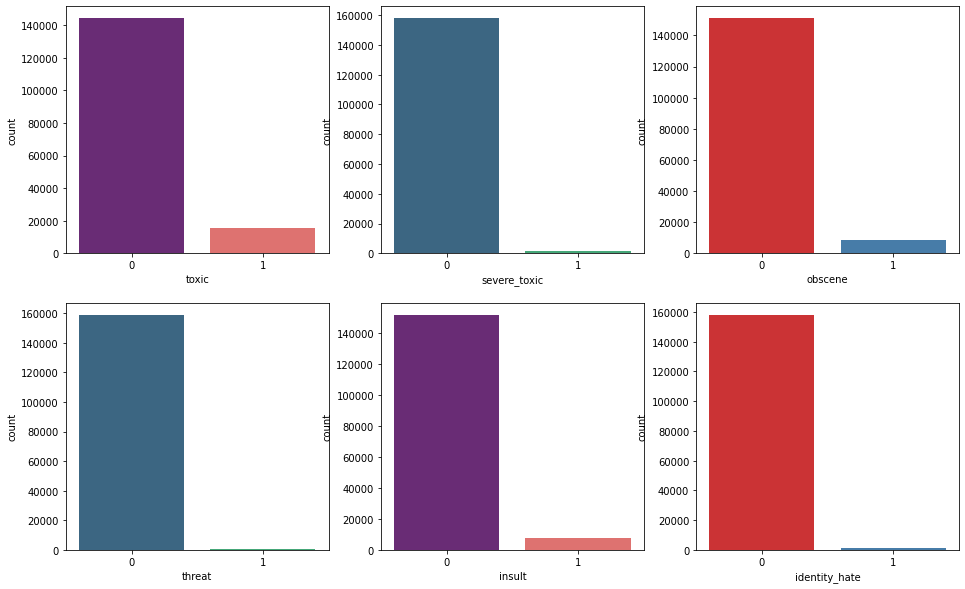

In [36]:
#distribution
fig,ax = plt.subplots(2,3,figsize=(16,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(train['toxic'],palette= 'magma',ax=ax1)
sns.countplot(train['severe_toxic'], palette= 'viridis',ax=ax2)
sns.countplot(train['obscene'], palette= 'Set1',ax=ax3)
sns.countplot(train['threat'], palette= 'viridis',ax = ax4)
sns.countplot(train['insult'], palette = 'magma',ax=ax5)
sns.countplot(train['identity_hate'], palette = 'Set1', ax = ax6)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


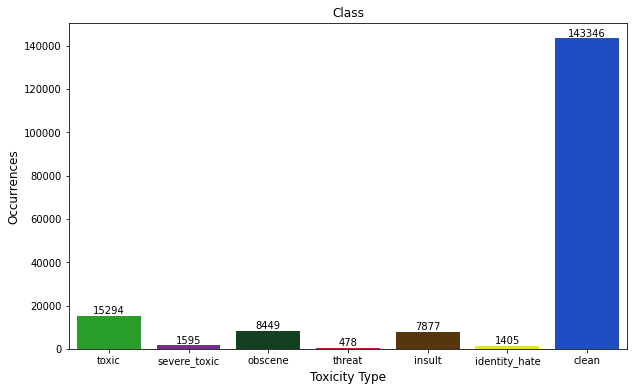

In [80]:

colors_list = ["green", "purple","pine green","red", "brown","yellow", "blue"]
palette= sns.xkcd_palette(colors_list)
x=train.iloc[:,2:].sum()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values,palette=palette)
plt.title("Class")
plt.xlabel('Toxicity Type', fontsize = 12)
plt.ylabel('Occurrences', fontsize=12)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')

plt.show()

In [40]:
checkMissing = pd.DataFrame()
checkMissing['train'] = train.isnull().sum()
checkMissing['test_data'] = test_data.isnull().sum()
print(checkMissing)

               train  test_data
id                 0        0.0
comment_text       0        0.0
toxic              0        NaN
severe_toxic       0        NaN
obscene            0        NaN
threat             0        NaN
insult             0        NaN
identity_hate      0        NaN


In [45]:
#No missing val
test_data['comment_text'].isnull().sum()

0

In [71]:
train.keys()

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [102]:
# Stemming and Lemmatizing 
import nltk

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, PorterStemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()






[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [96]:
#lower case
train['comment_text'] = train['comment_text'].apply(lambda x:x.lower())
test_data['comment_text'] = test_data['comment_text'].apply(lambda x:x.lower())
# Get rid of the special charactors
train['comment_text'] = train['comment_text'].str.replace('\W', ' ')
test_data['comment_text'] = test_data['comment_text'].str.replace('\W', ' ')
#get rid of the digit
train['comment_text']  = train['comment_text'].str.replace(r'\d+','')
test_data['comment_text']  = test_data['comment_text'].str.replace(r'\d+','')
#get rid of the leading space
train['comment_text'] = train['comment_text'] .str.strip()
test_data['comment_text'] = test_data['comment_text'] .str.strip()
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,0,0,0,0,0,0,True
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,True
3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,0,0,0,0,0,0,True
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,True
5,00025465d4725e87,congratulations well use tools well talk,0,0,0,0,0,0,True
6,0002bcb3da6cb337,cocksucker piss around work,1,1,1,0,1,0,False
7,00031b1e95af7921,vandalism matt shirvington article reverted pl...,0,0,0,0,0,0,True
8,00037261f536c51d,sorry word nonsense offensive anyway intending...,0,0,0,0,0,0,True
9,00040093b2687caa,alignment subject contrary dulithgow,0,0,0,0,0,0,True


In [79]:
# finding all the rows where the sum of labels is zero i.e the comment is a Clean comment
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
train['clean'].sum()
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,0,0,0,0,0,0,True
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,True
3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,0,0,0,0,0,0,True
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,True
5,00025465d4725e87,congratulations well use tools well talk,0,0,0,0,0,0,True
6,0002bcb3da6cb337,cocksucker piss around work,1,1,1,0,1,0,False
7,00031b1e95af7921,vandalism matt shirvington article reverted pl...,0,0,0,0,0,0,True
8,00037261f536c51d,sorry word nonsense offensive anyway intending...,0,0,0,0,0,0,True
9,00040093b2687caa,alignment subject contrary dulithgow,0,0,0,0,0,0,True


In [109]:
import nltk
# Remove the stop words
from nltk.corpus import stopwords
print(stopwords.words('english'))
stop_words = set(stopwords.words('english')) 
train['comment_text'] = train['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

train.head(10)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,0,0,0,0,0,0,True
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,True
3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,0,0,0,0,0,0,True
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,True
5,00025465d4725e87,congratulations well use tools well talk,0,0,0,0,0,0,True
6,0002bcb3da6cb337,cocksucker piss around work,1,1,1,0,1,0,False
7,00031b1e95af7921,vandalism matt shirvington article reverted pl...,0,0,0,0,0,0,True
8,00037261f536c51d,sorry word nonsense offensive anyway intending...,0,0,0,0,0,0,True
9,00040093b2687caa,alignment subject contrary dulithgow,0,0,0,0,0,0,True


In [112]:
# Turn python to spark
training_spark_df = spark.createDataFrame(train)
training_spark_df.show()
training_spark_df.printSchema()


+----------------+--------------------+-----+------------+-------+------+------+-------------+-----+
|              id|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|clean|
+----------------+--------------------+-----+------------+-------+------+------+-------------+-----+
|0000997932d777bf|explanation edits...|    0|           0|      0|     0|     0|            0| true|
|000103f0d9cfb60f|aww matches backg...|    0|           0|      0|     0|     0|            0| true|
|000113f07ec002fd|hey man really tr...|    0|           0|      0|     0|     0|            0| true|
|0001b41b1c6bb37e|make real suggest...|    0|           0|      0|     0|     0|            0| true|
|0001d958c54c6e35|sir hero chance r...|    0|           0|      0|     0|     0|            0| true|
|00025465d4725e87|congratulations w...|    0|           0|      0|     0|     0|            0| true|
|0002bcb3da6cb337|cocksucker piss a...|    1|           1|      1|     0|     1|           

TFIDF(t,d,D)=TF(t,d)⋅IDF(t,D). where IDF(t,D)=log(|D|+1/DF(t,D)+1).
TF is the number of times a term occurs within a document. This means that a term has different TF values for different documents of the corpus.
DF of a term is the number of documents having this term.Inverse Document Frequency - IDF

In [113]:
df = (training_spark_df
  .rdd
  .map(lambda x : (x.id,x.comment_text.split(" "),x.toxic,x.severe_toxic,x.obscene,x.threat,x.insult,x.identity_hate,x.clean))
  .toDF()
  .withColumnRenamed("_1","id")
  .withColumnRenamed("_2","comment_text")
  .withColumnRenamed("_3","toxic")
  .withColumnRenamed("_4","severe_toxic")
  .withColumnRenamed("_5","obscene")
  .withColumnRenamed("_6","threat")
  .withColumnRenamed("_7","insult")
  .withColumnRenamed("_8","identity_hate")
  .withColumnRenamed("_9","clean")

)
htf = HashingTF(inputCol="comment_text", outputCol="tf")
tf = htf.transform(df)

#tf.show(truncate=False)

idf = IDF(inputCol="tf", outputCol="idf")
tfidf = idf.fit(tf).transform(tf)
tfidf.show(truncate=False)

#hashingTF = HashingTF()
#tf = hashingTF.transform(training_spark_df)

#tf.cache()
#idf=IDF().fit(tf)
#tfidf = idf.transform(tf)

+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------